In [0]:
# install muscle command line
!wget https://www.drive5.com/muscle/downloads3.8.31/muscle3.8.31_i86linux64.tar.gz
!tar -zxvf muscle3.8.31_i86linux64.tar.gz
!ln -s $(pwd)/muscle3.8.31_i86linux64 /bin/muscle

# install clustalo command line
!wget http://www.clustal.org/omega/clustalo-1.2.4-Ubuntu-x86_64
!sudo chmod u+x clustalo-1.2.4-Ubuntu-x86_64
!ln -s $(pwd)/clustalo-1.2.4-Ubuntu-x86_64 /bin/clustalo 

--2019-10-03 22:10:38--  http://www.clustal.org/omega/clustalo-1.2.4-Ubuntu-x86_64
Resolving www.clustal.org (www.clustal.org)... 137.43.93.206
Connecting to www.clustal.org (www.clustal.org)|137.43.93.206|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4921774 (4.7M)
Saving to: ‘clustalo-1.2.4-Ubuntu-x86_64’

clustalo-1.2.4-Ubun 100%[===================>]   4.69M  2.49MB/s    in 1.9s    

2019-10-03 22:10:40 (2.49 MB/s) - ‘clustalo-1.2.4-Ubuntu-x86_64’ saved [4921774/4921774]



In [ ]:
from pathlib import Path
import os
from Bio import Entrez
from Bio import SeqIO
from Bio.Align.Applications import ClustalOmegaCommandline
from Bio import AlignIO
from Bio import Align
from Bio.SubsMat.MatrixInfo import blosum62
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

In [0]:
# Set up data folder
DATA = Path('/content/drive/My Drive/data')

## Pairwise alignment

Use multiple alignment to identify conservative regions of the [Histone H1](https://en.wikipedia.org/wiki/Histone_H1) protein. 

First, download the protein sequences of Histone H1 from 5 species.

In [0]:
histone_seqs = {
    "human": "AAA63187.1",
    "mouse": "AAA37814.1",
    "rat": "AAA41305.1",
    "chimp": "XP_003821619.1",
    "cow": "NP_001069955.1"
}

def save_genbank_protein(seq_id):
    Entrez.email = "myemail@columbia.edu"
    filename = "{}.fasta".format(seq_id.replace(",", "_"))
    if not os.path.isfile(filename):
        print("Downloading {}...".format(filename))
        handle = Entrez.efetch(db="protein", id=seq_id, rettype="fasta")
        output = open(filename, "w")
        output.write(handle.read())
        output.close()
        print("Saved {}".format(filename))
    return filename

In [0]:
fasta_file = save_genbank_protein(','.join([histone_seqs[s] for s in histone_seqs]))
fasta_file

Saved AAA63187.1_AAA37814.1_AAA41305.1_XP_003821619.1_NP_001069955.1.fasta


'AAA63187.1_AAA37814.1_AAA41305.1_XP_003821619.1_NP_001069955.1.fasta'

In [0]:
record = SeqIO.parse(open(fasta_file, 'r'),"fasta")

for seq in record:
    print("ID: {}, Length: {}".format(seq.id, len(seq)))
    
aln_file = 'histone.aln.fasta'
if not os.path.isfile(aln_file):  # if the file has not been created
    cline = ClustalOmegaCommandline(infile=fasta_file, outfile=aln_file, verbose=True, auto=True)
    print(cline)
    cline()

clustalo -i AAA63187.1_AAA37814.1_AAA41305.1_XP_003821619.1_NP_001069955.1.fasta -o histone.aln.fasta --auto -v


In [0]:
histone_aln = AlignIO.read(aln_file, 'fasta')
print(histone_aln)

SingleLetterAlphabet() alignment with 5 rows and 223 columns
MSETAPAAPA--APAPAEKTPVKKKARKSAGAAKRKASGPPVSE...KKK AAA63187.1
MSETAPAAPA--APAPAEKTPVKKKARKAAGGAKRKTSGPPVSE...KKK AAA37814.1
MSETAPAASSTLVPAPVEKPATKRRGKKPGMATARKPRGFSVSK...RK- AAA41305.1
MTENSTSAPA-------AK-------PKRAKASKKSTDHPKYSD...KKK XP_003821619.1
MTENSTSTPA-------AK-------PKRAKASKKSTDHPKYSD...KKK NP_001069955.1


In [0]:
# records is a list of sequences
records = [seq for seq in SeqIO.parse(fasta_file, format='fasta') if seq.seq != '']

# add back taxonomy:
tax_dict = dict([(histone_seqs[k], k) for k in histone_seqs])
for seq in records:
    seq.name = tax_dict[seq.name]
    
records

[SeqRecord(seq=Seq('MSETAPAAPAAPAPAEKTPVKKKARKSAGAAKRKASGPPVSELITKAVAASKER...KKK', SingleLetterAlphabet()), id='AAA63187.1', name='human', description='AAA63187.1 histone H1 [Homo sapiens]', dbxrefs=[]),
 SeqRecord(seq=Seq('MSETAPAAPAAPAPAEKTPVKKKARKAAGGAKRKTSGPPVSELITKAVAASKER...KKK', SingleLetterAlphabet()), id='AAA37814.1', name='mouse', description='AAA37814.1 histone H1 [Mus musculus domesticus]', dbxrefs=[]),
 SeqRecord(seq=Seq('MSETAPAASSTLVPAPVEKPATKRRGKKPGMATARKPRGFSVSKLIPEALSMSQ...GRK', SingleLetterAlphabet()), id='AAA41305.1', name='rat', description='AAA41305.1 histone H1 [Rattus norvegicus]', dbxrefs=[]),
 SeqRecord(seq=Seq('MTENSTSAPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQKYI...KKK', SingleLetterAlphabet()), id='XP_003821619.1', name='chimp', description='XP_003821619.1 histone H1.0 [Pan paniscus]', dbxrefs=[]),
 SeqRecord(seq=Seq('MTENSTSTPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQKYI...KKK', SingleLetterAlphabet()), id='NP_001069955.1', name='cow', description='NP_001

In [0]:
# Perform pairwise alignment for all pairs of the 5 sequences
aligner = Align.PairwiseAligner()
aligner.mode = "local"
aligner.open_gap_score = -10
aligner.extend_gap_score = -0.5

for i, a in enumerate(records):
    for b in records[i+1:]:
    
        aligner.substitution_matrix = blosum62  # use blosum62 to set match and mismatch scores
        alignments = aligner.align(a.seq, b.seq)

        print(f"{a.name} vs. {b.name}:")
        print(alignments.score)

# the following can print out the aligned sequences    
#     for aln in alignments:
#         print(aln)
#         print(f"Alignment score: {aln.score}")

human vs. mouse:
1006.0
human vs. rat:
490.5
human vs. chimp:
325.5
human vs. cow:
312.5
mouse vs. rat:
474.5
mouse vs. chimp:
322.0
mouse vs. cow:
316.0
rat vs. chimp:
229.0
rat vs. cow:
226.5
chimp vs. cow:
922.0


Human and mouse have the highest homology in histone H1.

## Dendrogram

The scores we got actually represent the _similarities_ between the sequences, while the _distances_ is a reverse concept from similarities. 

Distance vector: 
 [0.00099404 0.00203874 0.0030722  0.0032     0.00210748 0.00310559
 0.00316456 0.00436681 0.00441501 0.0010846 ]


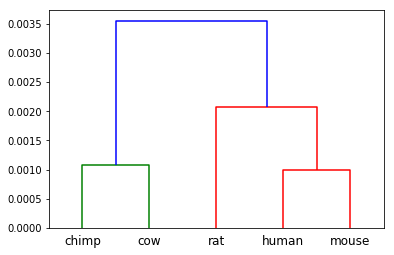

In [0]:
%matplotlib inline

# calculate the score matrix
score_matrix = np.zeros((len(records), len(records)))
for i, a in enumerate(records):
  for j, b in enumerate(records[:i]):  
    
    aligner.substitution_matrix = blosum62  # use blosum62 to set match and mismatch scores
    alignments = aligner.align(a.seq, b.seq)
    
    score_matrix[i, j] = alignments.score
    
# print(f"score matrix \n{score_matrix}")
score_matrix_trans = np.matrix.transpose(score_matrix)
# print(f"transpose of score_matrix \n{score_matrix_trans}")

score_vector = []
for i in range(score_matrix_trans.shape[0]):
  for j in range(i+1, score_matrix_trans.shape[1]):
    score_vector.append(score_matrix_trans[i, j])
    
score_vector = np.array(score_vector)

dist_vector = 1/score_vector
print("Distance vector: \n", dist_vector)

# cluster = average(dist_vector)
lk = linkage(dist_vector, method = 'average')
# plt.figure()
dn = dendrogram(lk, labels = list(histone_seqs.keys()))